# DEPENDANCIES AND LIBRARIES

In [ ]:
import os
import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib, os, random
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions



from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# DATA SET

In [ ]:
#print the directory
os.listdir('../input/fish-dataset/FishImgDataset')

In [ ]:
train = '../input/fish-dataset/FishImgDataset/train' #training path
validation = '../input/fish-dataset/FishImgDataset/val' #validation path
test = '../input/fish-dataset/FishImgDataset/test' #test path

In [ ]:
#DATA AUGMENTATION
train_datagen = ImageDataGenerator(rescale = 1./255, #convert to target values between 0 and 1 for faster training
                                   shear_range = 0.2, #for randomly applying shearing transformations 
                                   zoom_range = 0.2,  # for randomly zooming inside pictures
                                   horizontal_flip = True)#for randomly flipping half of the images horizontally)#initialize train generator 
valid_datagen = ImageDataGenerator(rescale = 1.0/255.) #initialize validation generator 
test_datagen = ImageDataGenerator(rescale = 1.0/255.) #initialize validation generator 

In [ ]:
#flow_from_directory it take the path to a directory & generates batches of augmented data.
#target_size the dimensions to which all images found will be resized
#batch_size the size of the batches of data (default: 32)
#class_mode determines the type of label arrays that are returned("categorical" for 2D labels,"binary" for 1D binary labels,"sparse" for 1D integer labels,and "input" for identical image
#shuffle use whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.

train_generator = train_datagen.flow_from_directory(train, target_size=(224,224),batch_size=32,class_mode='categorical')
validation_generator = valid_datagen.flow_from_directory(validation, target_size=(224,224),batch_size=32,class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test, target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=False)

# INCEPTION MODEL DECLARATION

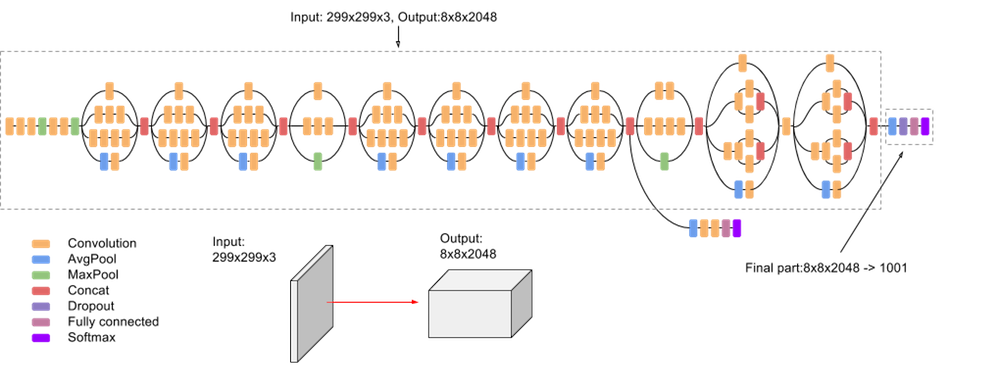

In [ ]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3))
#inception.summary()

In [ ]:
inception.trainable = True
for layer in inception.layers[:197]:
    layer.trainable = False 

In [ ]:
for idx, layer in enumerate(inception.layers):
    print(f' {idx}:  {layer.name}: trainable = {layer.trainable}')

In [ ]:
#get the last layer    
last_layer = inception.get_layer('mixed7')

layer_output = last_layer.output

In [ ]:
n_categories = len(os.listdir('../input/fish-dataset/FishImgDataset/train'))# number of categories
print(n_categories)

# Model Modification

In [ ]:
# x  = BatchNormalization()(layer_output)
xs = Flatten()(layer_output)
xs = Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(xs)
xs = Dropout(0.4)(xs)
xs = Dense(n_categories, activation='softmax')(xs)

model = Model(inputs=inception.inputs, outputs=xs)

# Compiling Model

In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# CALLBACKS

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# MODEL FITTING

In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 4,
            callbacks=[callback])

# LOSS AND VALIDATION LOSS

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# ACCURACY AND VALIDATION ACCURACY

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

# Saving of model Classfier

In [ ]:
model_name = 'FishModelClassifier_V6.h5'
model.save(model_name, save_format='h5')
model.save_weights('model_weights_V6.weights.h5')

# Accuracy of the model classifier in a new data

In [ ]:
results = model.evaluate(test_generator, verbose=0)


print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# Prediction of new data w/ Image

In [ ]:
class_names = ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin',
               'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer',
               'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish',
               'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp',
               'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']

# Use next() function instead of .next() method
images, labels = next(test_generator)
preds = model.predict(images)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25,25))
dic = {i: ax for i, ax in enumerate(axes.flat)}

for i in range(0, 8):
    label = np.argmax(labels[i])
    pred = np.argmax(preds[i])
    image = images[i]
    dic[i].set_title("real label: " + str(class_names[label]) + " v.s " + "predictedd lable: " + str(class_names[pred]))
    dic[i].imshow(image)

plt.tight_layout()
plt.show()

# Prediction of a new data

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt

# Use the actual model file that exists in your directory
model_path = './FishModelClassifier_V6.h5'

# Check if model file exists
if os.path.exists(model_path):
    print(f"Model file found at: {model_path}")
else:
    print(f"Error: Model file not found at {model_path}")
    print(f"Current directory contents: {os.listdir('.')}")
    # Stop execution if model not found
    raise FileNotFoundError(f"Model file not found at {model_path}")

# Load the model
try:
    model = load_model(model_path, compile=False)
    print(f"Model loaded successfully from: {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

class_names = ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin',
               'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer',
               'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish',
               'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp',
               'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']

def predict(path):
    # Check if image file exists
    if not os.path.exists(path):
        print(f"Image file not found at: {path}")
        return None
    
    try:
        img = load_img(path, target_size=(224, 224, 3))  # Convert image size and declare the kernel
        img = img_to_array(img)  # Convert the image to an image array
        img = img/255  # Normalize RGB values
        img = np.expand_dims(img, [0])
        answer = model.predict(img)
        x = list(np.argsort(answer[0])[::-1][:5])
        
        print("Top 5 predictions:")
        for i in x:
            print("{className}: {predVal:.2f}%".format(className=class_names[i], predVal=float(answer[0][i])*100))
        
        y_class = answer.argmax(axis=-1)
        y = " ".join(str(x) for x in y_class)
        y = int(y)
        res = class_names[y]
        
        return res
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Test with a sample image path - modify this to point to your actual test image
test_image_paths = [
    '../input/fish-dataset/FishImgDataset/test/Mudfish/Mudfish 013.jpg',
    './test_images/sample_fish.jpg',  # Alternative path
    './sample_fish.jpg'  # Another alternative
]

# Try to find a valid test image
test_image_found = False
for img_path in test_image_paths:
    if os.path.exists(img_path):
        print(f"Found test image at: {img_path}")
        result = predict(img_path)
        
        if result:
            print(f"Predicted species: {result}")
            
            # Display the image
            try:
                img = load_img(img_path, target_size=(224, 224, 3))
                plt.figure(figsize=(8, 6))
                plt.imshow(img, aspect="auto")
                plt.axis('off')
                plt.title(f"Predicted Fish Species: {result}")
                plt.show()
            except Exception as e:
                print(f"Error displaying image: {e}")
        
        test_image_found = True
        break

if not test_image_found:
    print("No test image found. Please provide a valid image path.")
    print("Available files in current directory:")
    for file in os.listdir('.'):
        if file.endswith(('.jpg', '.jpeg', '.png')):
            print(f"  - {file}")

# Visualize Feature Maps

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Get list of layers from model
layer_outputs = [layer.output for layer in model.layers[1:]]
# Create a visualization model
visualize_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)


In [ ]:
# Load image for prediction
img=load_img('../input/fish-dataset/FishImgDataset/test/Mudfish/Mudfish 013.jpg',target_size=(224,224))
# Convert image to array
x = img_to_array(img)
# Print shape of array
x.shape

# Reshape image for passing it to prediction
x=x.reshape((1,224,224,3))
print(x.shape)
# Rescale the image
x = x /255 

# Get all layers feature maps for image
feature_maps=visualize_model.predict(x)
print(len(feature_maps))
# Show names of layers available in model
layer_names = [layer.name for layer in model.layers]

In [ ]:
# Plotting the graph
for layer_names, feature_maps in zip(layer_names,feature_maps):
  print(feature_maps.shape)
  if len(feature_maps.shape) == 4 :
    channels = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    display_grid = np.zeros((size, size * channels))
    for i in range(channels):
      x = feature_maps[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / channels
    plt.figure(figsize=(scale * channels, scale))
    plt.title(layer_names)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# CONFUSION MATRIX

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap='rainbow'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "white")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# **FINE TUNING OF MODEL**

In [ ]:
import os
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Check what files are available in the current directory
print("Files in current directory:")
for file in os.listdir('.'):
    if file.endswith(('.h5', '.hdf5', '.weights.h5')):
        print(f"  - {file}")

# Method 1: If you have a complete model file (not just weights)
# Use load_model() instead of creating model + load_weights()
try:
    # Try to load the complete model first
    model_files = [f for f in os.listdir('.') if f.startswith('FishModelClassifier') and f.endswith('.h5')]
    
    if model_files:
        model_path = f'./{model_files[0]}'
        print(f"Loading complete model from: {model_path}")
        model = load_model(model_path, compile=False)
        print("Model loaded successfully!")
        
    else:
        # Method 2: If you need to create the model architecture first
        print("No complete model file found. Creating model architecture...")
        
        # You need to recreate the exact same model architecture that was used during training
        # This is just an example - replace with your actual model architecture
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(31, activation='softmax')  # 31 classes for fish species
        ])
        
        # Compile the model
        model.compile(optimizer='adam', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
        
        # Now try to load weights
        weights_files = [f for f in os.listdir('.') if 'weights' in f.lower() and f.endswith('.h5')]
        
        if weights_files:
            weights_path = f'./{weights_files[0]}'
            print(f"Loading weights from: {weights_path}")
            model.load_weights(weights_path)
            print("Weights loaded successfully!")
        else:
            print("No weights file found. Available files:")
            print(os.listdir('.'))
            raise FileNotFoundError("Neither complete model nor weights file found")

except FileNotFoundError as e:
    print(f"File not found error: {e}")
    print("\nTroubleshooting steps:")
    print("1. Check if the model/weights file exists in the current directory")
    print("2. Verify the file name and path are correct")
    print("3. Make sure the file was saved properly during training")
    raise

except Exception as e:
    print(f"Error loading model: {e}")
    print("\nThis might be due to:")
    print("1. Model architecture mismatch")
    print("2. Corrupted model/weights file")
    print("3. Version compatibility issues")
    raise

# Test that the model is working
try:
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    print("Model loaded and ready for predictions!")
except Exception as e:
    print(f"Error testing model: {e}")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)



inception.trainable = False
for layer in model.layers[:290]:
   layer.trainable = False
for layer in model.layers[290:]:
   layer.trainable = True

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Set up model checkpoint
filepath = "./FishModelClassifier.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, learning_rate_reduction]

# Training parameters
steps_per_epoch = 32

# Use model.fit() instead of fit_generator()
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2
)

In [ ]:
import tensorflow as tf

# Check if test_generator is properly defined
if 'test_generator' not in locals():
    print("Error: test_generator not defined. Please ensure you have created your test data generator.")
else:
    try:
        # Use model.evaluate() - works with generators in TensorFlow 2.x
        print("Evaluating model on test data...")
        
        # If batch_size is not defined, remove it or set a default
        if 'batch_size' not in locals():
            batch_size = 32  # Set default batch size
        
        # Evaluate the model
        test_score = model.evaluate(test_generator, verbose=1)
        
        # Display results
        print(f"[INFO] Test Loss: {test_score[0]:.4f}")
        print(f"[INFO] Test Accuracy: {test_score[1]*100:.2f}%")
        
    except Exception as e:
        print(f"Error during model evaluation: {e}")
        
        # Fallback for very old TensorFlow versions (unlikely but just in case)
        if hasattr(model, 'evaluate_generator'):
            print("Falling back to evaluate_generator for older TensorFlow version...")
            test_score = model.evaluate_generator(test_generator, batch_size)
            print(f"[INFO] Test Accuracy: {test_score[1]*100:.2f}%")
            print(f"[INFO] Test Loss: {test_score[0]:.4f}")
        else:
            print("Both evaluate() and evaluate_generator() methods failed.")
            raise e

In [ ]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from PIL import Image
import io
import numpy as np
from keras.preprocessing.image import img_to_array
import os

# Define class names for fish species
class_names = ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin',
               'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer',
               'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish',
               'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp',
               'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']

# Create output widgets for results
output = widgets.Output()
result_output = widgets.Output()

def preprocess_image(image):
    """Preprocess the image for model prediction"""
    try:
        # Resize image to match model input (224x224)
        image = image.resize((224, 224))
        
        # Convert to array
        img_array = img_to_array(image)
        
        # Normalize pixel values (0-1)
        img_array = img_array / 255.0
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        return img_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

def predict_fish_species(image_array):
    """Make prediction using the trained model"""
    try:
        # Make prediction
        predictions = model.predict(image_array, verbose=0)
        
        # Get top 3 predictions
        top_indices = np.argsort(predictions[0])[::-1][:3]
        
        results = []
        for i, idx in enumerate(top_indices):
            confidence = predictions[0][idx] * 100
            results.append((class_names[idx], confidence))
        
        return results
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

def on_upload_change(change):
    """Handle file upload - Fixed for newer ipywidgets versions"""
    with output:
        clear_output(wait=True)
        
        # Check if files were uploaded
        if change['new']:
            try:
                # In newer versions of ipywidgets, change['new'] is a tuple of file dictionaries
                if isinstance(change['new'], tuple) and len(change['new']) > 0:
                    # Get the first uploaded file from the tuple
                    uploaded_file = change['new'][0]
                elif isinstance(change['new'], dict):
                    # For older versions where it might still be a dict
                    uploaded_file = list(change['new'].values())[0]
                else:
                    print("No files uploaded or unexpected file format")
                    return
                
                # Debug: Check the structure of uploaded_file
                print(f"File info: {uploaded_file.get('name', 'Unknown')} ({uploaded_file.get('size', 0)} bytes)")
                
                # Load image from uploaded bytes
                image = Image.open(io.BytesIO(uploaded_file['content']))
                
                # Convert to RGB if needed
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                
                # Display the uploaded image
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.axis('off')
                plt.title(f'Uploaded Image: {uploaded_file.get("name", "Unknown")}')
                plt.show()
                
                # Preprocess image
                processed_image = preprocess_image(image)
                
                if processed_image is not None:
                    # Make prediction
                    with result_output:
                        clear_output(wait=True)
                        print("🐟 Analyzing image...")
                        
                        predictions = predict_fish_species(processed_image)
                        
                        if predictions:
                            print("\n" + "="*50)
                            print("🔍 FISH SPECIES PREDICTION RESULTS")
                            print("="*50)
                            
                            for i, (species, confidence) in enumerate(predictions, 1):
                                if i == 1:
                                    print(f"🥇 TOP PREDICTION: {species}")
                                    print(f"   Confidence: {confidence:.2f}%")
                                else:
                                    print(f"#{i}  {species}: {confidence:.2f}%")
                            
                            print("\n" + "="*50)
                            
                            # Show confidence level interpretation
                            top_confidence = predictions[0][1]
                            if top_confidence > 90:
                                print("✅ Very High Confidence - Excellent prediction!")
                            elif top_confidence > 70:
                                print("✅ High Confidence - Good prediction!")
                            elif top_confidence > 50:
                                print("⚠️  Moderate Confidence - Consider additional verification")
                            else:
                                print("❌ Low Confidence - Image may be unclear or species not well represented")
                
            except Exception as e:
                print(f"❌ Error processing image: {e}")
                print("Please try uploading a different image file (JPG, PNG, or JPEG)")

def predict_from_path():
    """Predict from a file path input"""
    file_path = path_input.value.strip()
    
    with path_output:
        clear_output(wait=True)
        
        if not file_path:
            print("Please enter a valid file path")
            return
        
        if not os.path.exists(file_path):
            print(f"❌ File not found: {file_path}")
            return
        
        try:
            # Load image from path
            image = Image.open(file_path)
            
            # Convert to RGB if needed
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Display the image
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f'Image: {os.path.basename(file_path)}')
            plt.show()
            
            # Preprocess and predict
            processed_image = preprocess_image(image)
            
            if processed_image is not None:
                predictions = predict_fish_species(processed_image)
                
                if predictions:
                    print("\n" + "="*50)
                    print("🔍 FISH SPECIES PREDICTION RESULTS")
                    print("="*50)
                    
                    for i, (species, confidence) in enumerate(predictions, 1):
                        if i == 1:
                            print(f"🥇 TOP PREDICTION: {species}")
                            print(f"   Confidence: {confidence:.2f}%")
                        else:
                            print(f"#{i}  {species}: {confidence:.2f}%")
        
        except Exception as e:
            print(f"❌ Error processing image: {e}")

# Create upload widget
upload_widget = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',  # Accept image files
    multiple=False,
    description='Upload Fish Image',
    tooltip='Select a fish image for classification'
)

# Create file path input widget
path_input = widgets.Text(
    placeholder='Enter image file path...',
    description='File Path:',
    style={'description_width': 'initial'}
)

# Create button for path prediction
path_button = widgets.Button(
    description='Predict from Path',
    button_style='info',
    tooltip='Click to predict from file path'
)

# Create output widget for path predictions
path_output = widgets.Output()

# Connect widgets to functions
upload_widget.observe(on_upload_change, names='value')
path_button.on_click(lambda x: predict_from_path())

# Create the user interface
print("🐟 FISH SPECIES CLASSIFICATION SYSTEM")
print("="*50)
print("Choose one of the following methods to classify a fish image:")

# Method 1: File Upload
print("\n📤 METHOD 1: Upload Image File")
display(upload_widget)
display(output)
display(result_output)

print("\n" + "-"*50)

# Method 2: File Path Input
print("\n📁 METHOD 2: Enter Image File Path")
display(widgets.HBox([path_input, path_button]))
display(path_output)

print("\n" + "="*50)
print("📋 INSTRUCTIONS:")
print("• Upload a clear image of a fish (JPG, PNG, or JPEG format)")
print("• Ensure the fish is clearly visible and well-lit")
print("• The model can classify 31 different fish species")
print("• Higher confidence scores indicate more reliable predictions")


# Save full model
model.save("FishModelClassifier.h5")
print("Saved FishModelClassifier.h5")
